## 1.半监督学习算法

半监督学习的算法适用于只有正常数据，没有异常数据的情况下，这种异常值检测也被称作为新奇点检测。这类算法主要有：

    Local Outlier Factor（LOF）
    
    One-Class SVM

**数据准备**

解释：因为是训练模型，所以这里人为的加入了标签，目的在于评价模型预测结果

**训练集**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

#这里是脱敏数据，使用修改路径即可
data = pd.read_csv("E:/bladed/test26-abnormal-train.csv")

X = data[data.columns[3:-1]]
y = data['target']

print(X.shape)
print(y.shape)
print(y.value_counts())   #1 代表正常，只有正常数据

(49999, 13)
(49999,)
1    49999
Name: target, dtype: int64


**测试集**

In [2]:
test = pd.read_csv("E:/bladed/test26_test.csv")
X_test = test[test.columns[3:-1]]
y_test = test['target']
print(X_test.shape)
print(y_test.shape)
print(y_test.value_counts())   #1 代表正常，-1代表异常

(701, 13)
(701,)
 1    502
-1    199
Name: target, dtype: int64


In [3]:
#数据标准化
from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(X)
X_test = StandardScaler().fit_transform(X_test)

### 1. Local Outlier Factor（LOF）


#### 1.1 LOF 训练

LOF通过计算一个数值score来反映一个样本的异常程度。 这个数值的大致意思是：

    一个样本点周围的样本点所处位置的平均密度比上该样本点所在位置的密度。比值越大于1，则该点所在位置的密度越小于其周围样本所在位置的密度。
    
    
    
    
方法	|离群点检测`novelty = False`|新奇点检测`novelty = True`
--|--|--|
fit_predict|	可用	|不可用
predict	|不可用	|只能用于新数据
decision_function|	不可用	|只能用于新数据
score_samples	|用 negative_outlier_factor_	|只能用于新数据

In [4]:
from sklearn.neighbors import LocalOutlierFactor

LOF = LocalOutlierFactor(n_neighbors=100, algorithm='auto', leaf_size=10, metric='minkowski', p=3,
                         metric_params=None, contamination='auto', novelty=True, n_jobs=-1).fit(X)
LOF_predict = LOF.predict(X)

In [6]:
from sklearn.metrics import confusion_matrix   #混淆矩阵
from sklearn.metrics import accuracy_score     #准确率
from sklearn.metrics import precision_score    #精确率
from sklearn.metrics import recall_score       #召回率
from sklearn.metrics import f1_score           #F1-得分
from sklearn.metrics import classification_report

print("混淆矩阵：")
print(confusion_matrix(y,LOF_predict))
print("标准化混淆矩阵：")
print(confusion_matrix(y,LOF_predict,normalize='true'))
print("得分详细：")
print(classification_report(y,LOF_predict))

混淆矩阵：
[[    0     0]
 [   15 49984]]
标准化混淆矩阵：
[[0.00000000e+00 0.00000000e+00]
 [3.00006000e-04 9.99699994e-01]]
得分详细：
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           1       1.00      1.00      1.00     49999

    accuracy                           1.00     49999
   macro avg       0.50      0.50      0.50     49999
weighted avg       1.00      1.00      1.00     49999



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**1.2 LOF 训练结果评价**

`classification_report`每个分类标签的精确度，召回率和 F1-score。

    精确度：`precision`，正确预测为正的，占全部预测为正的比例，
$$TP / (TP+FP)$$
    
    召回率：`recall`，正确预测为正的，占全部实际为正的比例，
$$TP / (TP+FN)$$
    
    `F1-score`：精确率和召回率的调和平均数，
$$2 * precision*recall /(precision+recall)$$
    
同时还会给出总体的微平均值，宏平均值和加权平均值。

    微平均值：micro average，所有数据结果的平均值
    
    宏平均值：macro average，所有标签结果的平均值
    
    加权平均值：weighted average，所有标签结果的加权平均值
    
在二分类场景中，正标签的召回率称为敏感度（sensitivity），负标签的召回率称为特异性（specificity）。

#### 1.3 LOF测试

In [8]:
LOF_test = LOF.predict(X_test)
print("混淆矩阵：")
print(confusion_matrix(y_test,LOF_test))
print("标准化混淆矩阵：")
print(confusion_matrix(y_test,LOF_test,normalize='true'))
print("得分详细：")
print(classification_report(y_test,LOF_test))

混淆矩阵：
[[175  24]
 [ 64 438]]
标准化混淆矩阵：
[[0.87939698 0.12060302]
 [0.12749004 0.87250996]]
得分详细：
              precision    recall  f1-score   support

          -1       0.73      0.88      0.80       199
           1       0.95      0.87      0.91       502

    accuracy                           0.87       701
   macro avg       0.84      0.88      0.85       701
weighted avg       0.89      0.87      0.88       701



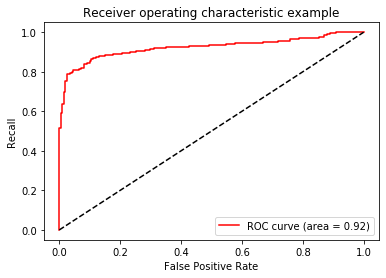

In [9]:
from sklearn.metrics import roc_curve          #ROC曲线
from sklearn.metrics import roc_auc_score      #AUC面积

area = roc_auc_score(y_test,LOF.decision_function(X_test))
FPR, recall, thresholds = roc_curve(y_test,LOF.decision_function(X_test))

plt.figure()
plt.plot(FPR, recall, color='red',label='ROC curve (area = %0.2f)' % area)
plt.plot([0, 1], [0, 1], color='black',linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('Recall')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### 2. One-Class SVM


#### 2.1 One-Class SVM 训练

In [29]:
from sklearn.svm import OneClassSVM
OSVM = OneClassSVM(kernel='rbf', degree=3, nu=0.01,gamma=0.1, coef0=0.0, tol=0.001,shrinking=True, 
                   cache_size=5000, verbose=False, max_iter=-1).fit(X)
OSVM_predict = OSVM.predict(X)

In [30]:
print("混淆矩阵：")
print(confusion_matrix(y,OSVM_predict))
print("标准化混淆矩阵：")
print(confusion_matrix(y,OSVM_predict,normalize='true'))
print("得分详细：")
print(classification_report(y,OSVM_predict))

混淆矩阵：
[[    0     0]
 [  519 49480]]
标准化混淆矩阵：
[[0.         0.        ]
 [0.01038021 0.98961979]]
得分详细：
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           1       1.00      0.99      0.99     49999

    accuracy                           0.99     49999
   macro avg       0.50      0.49      0.50     49999
weighted avg       1.00      0.99      0.99     49999



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### 2.2 One-Class SVM 测试

In [31]:
OSVM_test = OSVM.predict(X_test)
print("混淆矩阵：")
print(confusion_matrix(y_test,OSVM_test))
print("标准化混淆矩阵：")
print(confusion_matrix(y_test,OSVM_test,normalize='true'))
print("得分详细：")
print(classification_report(y_test,OSVM_test))

混淆矩阵：
[[193   6]
 [ 96 406]]
标准化混淆矩阵：
[[0.96984925 0.03015075]
 [0.19123506 0.80876494]]
得分详细：
              precision    recall  f1-score   support

          -1       0.67      0.97      0.79       199
           1       0.99      0.81      0.89       502

    accuracy                           0.85       701
   macro avg       0.83      0.89      0.84       701
weighted avg       0.90      0.85      0.86       701



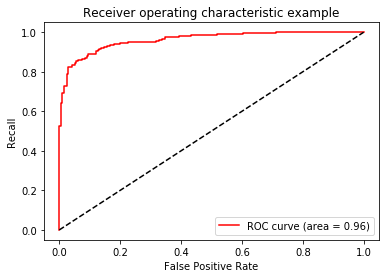

In [32]:
area = roc_auc_score(y_test,OSVM.decision_function(X_test))
FPR, recall, thresholds = roc_curve(y_test,OSVM.decision_function(X_test))

plt.figure()
plt.plot(FPR, recall, color='red',label='ROC curve (area = %0.2f)' % area)
plt.plot([0, 1], [0, 1], color='black',linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('Recall')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

<center><h1>总结 </h1></center>


半监督学习的算法适用于只有正常数据，没有异常数据的情况下，这种异常值检测也被称作为新奇点检测。这类算法主要有：

    Local Outlier Factor（LOF）

    One-Class SVM

